# ch.6 학습 관련 기술들

이번 장에서는 신경망 학습의 핵심 개념들을 만나봅니다. 이번 장에서 다룰 주제는 가중치 매개변수의 최적값을 탐색하는 최적화 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등, 모두가 신경망 학습에서 중요한 주제입니다. 오버피팅의 대응책인 가중치 감소와 드롭아웃 등의 정규화 방법도 간략히 설명하고 구현해봅니다. 마지막으로 최근 많은 연구에서 사용하는 배치 정규화도 짧게 알아봅니다. 이번 장에서 설명하는 기법을 이용하면 신경망(딥러닝) 학습의 효율과 정확도를 높일 수 있습니다. 그럼 본론으로 들어가 볼까요?


## 6.1 매개변수 갱신


- 신경망 학습의 목적 : 손실함수의 값을 최대한 낮추는 매개변수를 찾는 것.  
= 매개변수의 최적값을 찾는 것!  
=> 최적화 (optimization)  

- 지금까지 최적의 매개변수를 찾기 위해서 매개변수의 기울기(미분)을 이용해 왔다.  
매개변수의 기울기를 구해, 기울어진 방향으로 매개변수 값을 갱신하는 일을 몇번이고 반복해서 점점 최적의 값에 다가감.
#### => 확률적 경사 하강법 (SGD)   
: 단순하다.


shb-deep-learning-from-scratch/YJ/ch.6/1.png
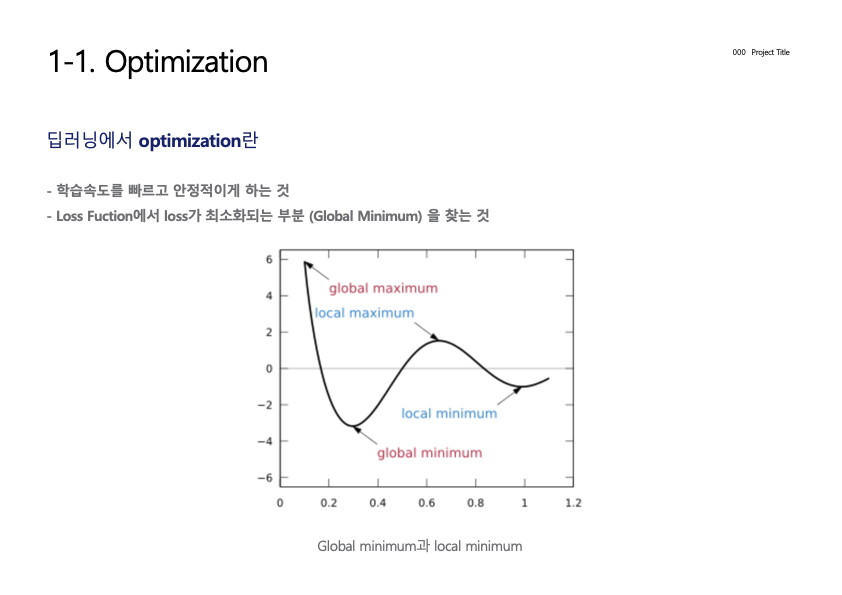

### 6.1.1 모험가 이야기

- 최적화를 해야 하는 상황을 깊은 골짜기(깊은 곳)을 찾는 모험가 이야기에 비유.

- 모험(최적화)의 목적 : 깊은 곳(최적값)을 찾는 것.  
- 제약 2개가 있음.  
1) 지도를 보지 않을 것.  
2) 눈가리개를 쓰는 것.

-> 이러한 상황에서는 땅의 '기울기'가 중요한 단서가 됨.  
#### 지금 서있는 땅의 기울기를 알 수 있으니, 지금 서있는 곳에서 가장 크게 기울여진 방향으로 가자!  
=> SGD의 전략


### 6.1.2 확률적 경사 하강법(SGD) 

- SGD의 수식  
#### W <- W - (n * dN/dW)   
(: 기울여진 방향으로 일정 거리만 가겠다.)

W : 갱신할 가중치 매개변수  
dL/dW : W에 대한 손실 함수의 기울기  
n : 학습률. 보통 0.01이나 0.001 같은 값을 미리 정해서 사용함.  
<- : 우변의 값으로 좌변의 값 갱신

In [2]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01): # 초기화 때 learning rate(학습률) 0.01
        self.lr = lr 
        
    def update(self, params, grads): #  params : 가중치 매개변수값들, grads : 기울기값들 저장하고 있는 딕셔너리 변수
        for key in params.keys(): 
            params[key] -= self.lr * grads[key] # pramas의 값(W 값)을 기존 params의 값에서 학습률에 기울기를 곱한 값으로 갱신.

- params : 가중치 매개변수(W)값들  
- grads : 기울기값들 저장하고 있는 딕셔너리 변수  
- update 메서드는 SGD 과정에서 반복적으로 쓰임.  

In [ ]:
# 실제로는 작동하지 않는 의사코드임.

network = TwoLayerNet(...)
optimizer = SGD() # 원하는 optimizer로 바꿔주면 됨.

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...) # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...

### 6.1.3 SGD의 단점  


- 단순하고 구현도 쉽지만, 문제에 따라서는 비효율적일 때가 있음.  
- 비등방성 함수(방향에 따라서 성질, 여기에서는 기울기가 달라지는 함수)에서는 탐색 경로가 비효율적.  
- SGD가 지그재그로 탐색하는 근본 원인은 기울어진 방향이 본래의 최솟값과 다른 방향을 가리켜서라는 점도 고려해봐야 함.  
- SGD의 단점을 개선해주는 모멘텀, AdaGrad, Adam에 대해 알아보자.  

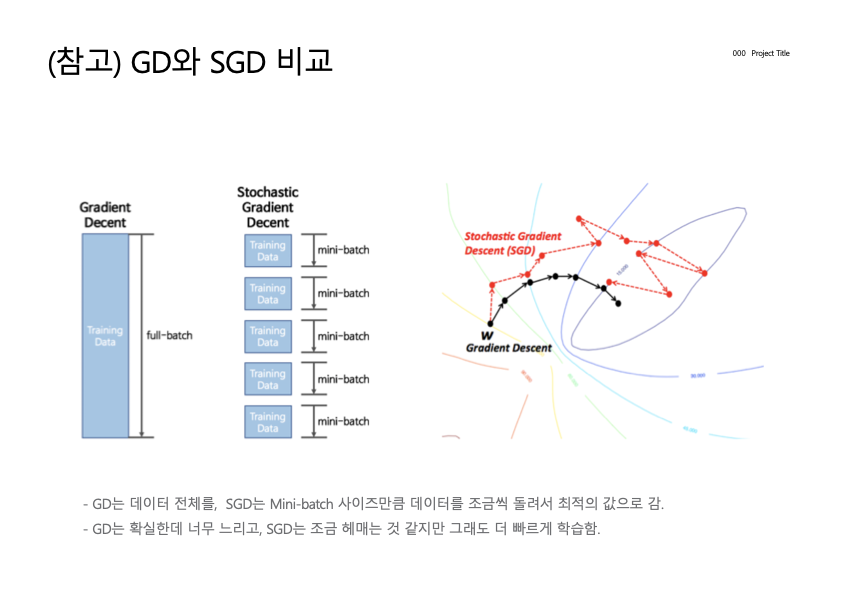

### 6.1.4 모멘텀


- 모멘텀(momentum): 운동량
- 수식 :  
#### v <- av - n*dL/dW     --- 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 나타냄.
#### W <- W + v               
----

W : 갱신할 가중치 매개변수  
dL/dW : W에 대한 손실 함수의 기울기  
n : 학습률. 
v : 속도(velocity)  

- av항은 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할. like 지면 마찰, 공기 저항 (보통 a=0.9로 설정) 

In [3]:
class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val) # 초기값 0으로 설정
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

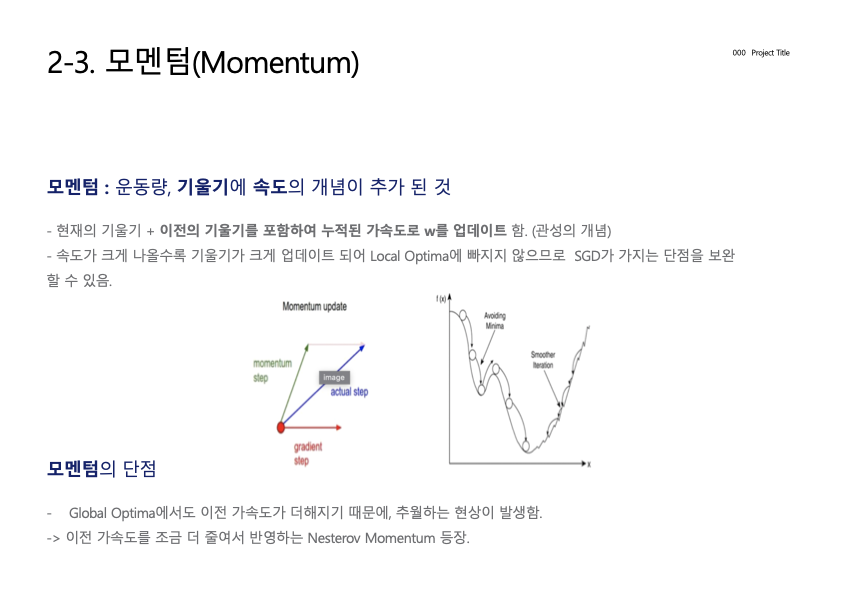

### 6.1.5 AdaGrad 


- 신경망 학습에서는 학습률 값이 중요함.  
너무 작으면 학습 시간이 길어지고, 너무 크면 발산하여 학습이 제대로 이뤄지지 않음.  
이 학습률을 효과적으로 정하는 기술로 학습률 감소(learning rate decay)가 있음.  
= 학습을 진행하면서 학습률을 점차 줄여가는 방법.  


- 가장 간단한 방법은 매개변수 '전체'의 학습률 값을 일괄적으로 낮춰 주는 것.  
--> '각각의' 매개변수에 '맞춤형'값을 만들어주는 것이 AdaGrad!

- 수식:  
h <- h+ (dL/dW * dL/dW)  
W <- W - n*1/rout(h)*dL/dW  



- h : 기존 기울기 값을 제곱하여 계속 더해줌.  
- 매개변수 갱신 시 1/rout(h)를 곱해 학습률을 조정함.  
--> 매개변수의 원소중에서 많이 움직인 (크게 갱신된) 원소는 학습률이 낮아진다는 뜻.   
= 학습률의 감소가 매개변수의 원소마다 다르게 적용됨을 의미.



In [5]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) 
            # 1e-7 이라는 작은 값을 더함으로써 self.h[key]에 0이 담겨 있다 해도 0으로 나눠주는 사태를 방지.

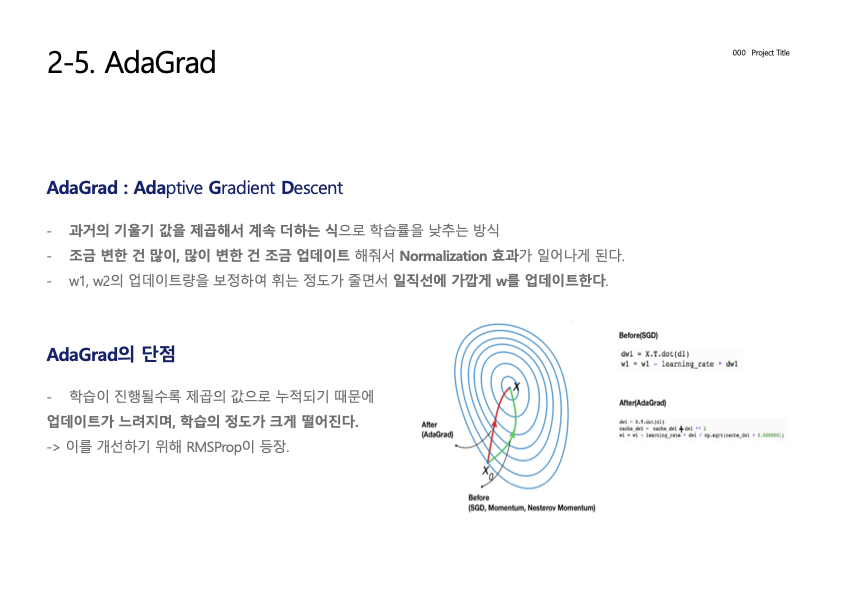

AdaGrad는 과거의 기울기를 제곱하여 계속 더해나가기 때문에, 학습을 진행할수록 갱신 강도가 약해짐.  
실제로 무한히 계속 학습하다 보면 어느순간 갱신량이 0이 되어 전혀 갱신하지 않게 됨.  
-> 이를 개선하기 위해 등장한 것이  
#### RMSProp
: 과거 기울기는 반영을 적게 하고 새로운 기울기 정보를 크게 반영함.  

In [6]:
class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate # decay_rate라는 변수를 이용해 학습의 갱신 강도를 조절.
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key] 
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

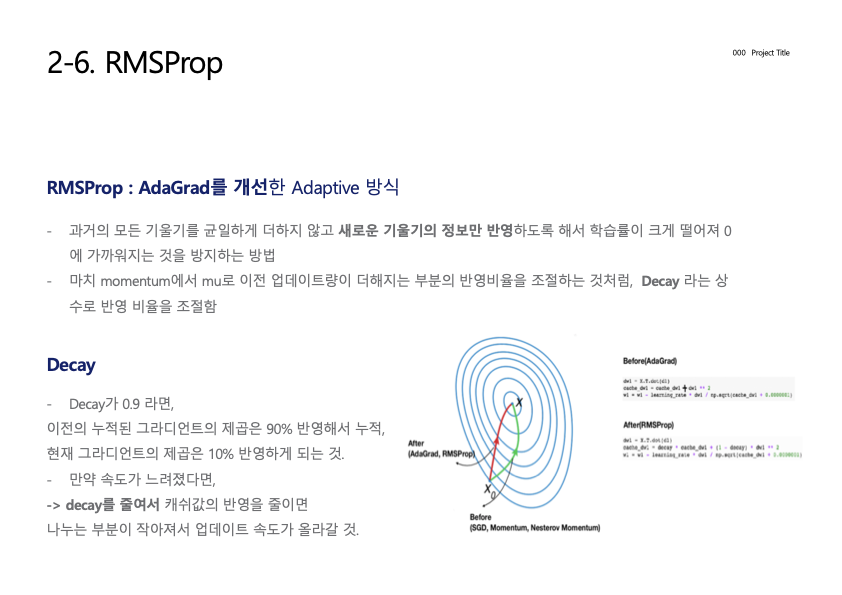

### 6.1.6 Adam


- Momentum + AdaGrad  
- 하이퍼파라미터의 '편향 보정'이 진행된다는 특징이 있음.
- 모멘텀과 비슷한 패턴인데, 학습의 갱신 강도를 적응적으로(Adaptive 하게) 조정하기 때문에 모멘텀보다 좌우 흔들림이 적음.  

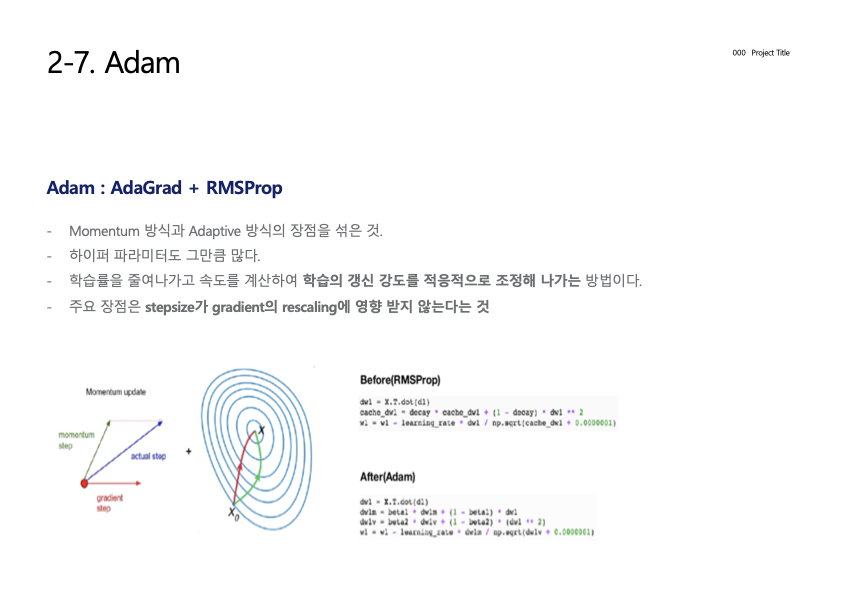

In [7]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

- Adam은 하이퍼파라미터를 3개 설정함.  
1) 학습률  
2) 일차 모멘텀용 계수 beta1 (기본값 : 0.9)  
3) 이차 모멘텀용 계수 beta2 (기본값 : 0.999)

### 6.1.7 어느 갱신 방법을 이용할 것인가?


- 위의 4가지 기법의 결과를 비교해보자.  
(ch06/optimizer_compare_naive.py 코드)

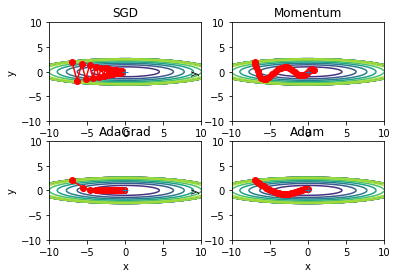

In [9]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

- AdaGrad가 나아 보이지만, 결과는 풀어야 할 문제가 무엇인지에 따라 달라지므로 주의해야 함.  
학습률 등의 하이퍼파라미터를 어떻게 설정하느냐에 따라서도 결과가 바뀜.  
각각의 장단이 있기 때문에, 어떤 기법이 정답이라고 딱 말할 수는 없음.  
지금도 많은 연구에서 SGD를 사용하고 있으며, 모멘텀과 Adam도 시도해볼 만한 가치가 충분하다.  

### 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교

(ch06/optimizer_compare_mnist.py)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
===========iteration:0===========
SGD:2.401579487603504
Momentum:2.4006100258788283
AdaGrad:2.1277950184518493
Adam:2.1900523157928955
===========iteration:100===========
SGD:1.7307815635971817
Momentum:0.3101386486093922
AdaGrad:0.18677720363178707
Adam:0.29650150660734886
===========iteration:200===========
SGD:0.9177889119670395
Momentum:0.40694128300150145
AdaGrad:0.14514608138822768
Adam:0.2710063415749361
===========iteration:300===========
SGD:0.6654825892409951
Momentum:0.19730378125501313
AdaGrad:0.05644483951135105
Adam:0.1251183483843775
===========iteration:400===========
SGD:0.38434232425197706
Momentum:0.16339704765427446
AdaGrad:0.0642849398262067
Adam:0.12261807376298256
=======

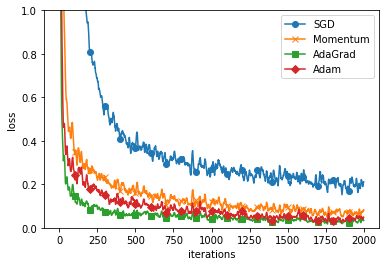

In [11]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

- SGD의 학습 속도가 제일 느리고, 나머지 3개는 비슷한데 그 중에서 AdaGrad가 가장 빠르다.  
#### 주의! 하이퍼파라미터인 학습률과 신경망의 구조(층 깊이 등)에 따라 결과가 달라진 다는 점!